# Data processing using `iblphotometry` pipelines
This notebook covers on how to process photometry data using the the `pipelines` functionality of `iblphotometry`

In [1]:
# imports and data loading
from iblphotometry import processing, pipelines
from brainbox.io.one import PhotometrySessionLoader
from one.api import ONE

one = ONE()
eid = 'a1ccc8ed-9829-4af8-91fd-cc1c83b74b98'
psl = PhotometrySessionLoader(eid=eid, one=one)
psl.load_photometry()

## Definition of a pipeline
A processing pipeline is a sequence of processing steps. The steps are applied in a sequence, and each step is implemented by a single callable function. Within the pipeline, each function must know its input(s) and output.

In code, a pipeline is a `list` of `dict` which represent the steps. Each step has the keys
 - function: the name of the processing function (a `callable`)
 - parameters: it's parameters (a `dict`)
 - inputs: a `tuple` of `str`. The names of the input. These are free to chose except the first photometry signal input must be named `signal` and the first reference input must be named `reference` (optional). The reason for this being a tuple is that certain processing steps require multiple inputs (such as isosbestic correction)
 - output: a `str` with the name of the output of the processing step. Again, free to chose, except the final result of the pipeline must be named `result`.


In [3]:
# a list (2 elements) of dict, first an exponential bleach correct, then a z score
custom_pipeline = [
    dict(
        function=processing.exponential_bleachcorrect,
        parameters=dict(
            order=1,
            correction_method='subtract',
        ),
        inputs=('signal',),
        output='bleach_corrected',
    ),
    dict(
        function=processing.zscore,
        parameters=dict(mode='classic'),
        inputs=('bleach_corrected',),
        output='result',
    ),
]

Pipelines are executed using the `run_pipeline` function which takes the pipeline and the signal to be processed. A Signal is the a `pd.Series`

<Axes: xlabel='times'>

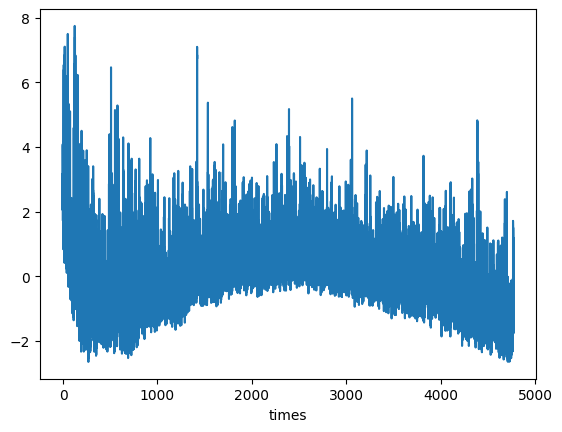

In [4]:
signal = psl.photometry['GCaMP']['VTA']
signal_processed = pipelines.run_pipeline(custom_pipeline, signal)
signal_processed.plot()

Here is an example of a more involved pipeline (isosbestic correction)

In [ ]:
isosbestic_correction_pipeline = [
    dict(
        function=processing.lowpass_bleachcorrect,
        parameters=dict(
            correction_method='subtract-divide',
            N=3,
            Wn=0.01,
        ),
        inputs=('signal',),
        output='signal_bleach_corrected',
    ),
    dict(
        function=processing.lowpass_bleachcorrect,
        parameters=dict(
            correction_method='subtract-divide',
            N=3,
            Wn=0.01,
        ),
        inputs=('reference',),
        output='reference_bleach_corrected',
    ),
    dict(
        function=processing.isosbestic_correct,
        parameters=dict(
            regression_method='mse',
            correction_method='subtract',
        ),
        inputs=('signal_bleach_corrected', 'reference_bleach_corrected'),
        output='isosbestic_corrected',
    ),
    dict(
        function=processing.zscore,
        parameters=dict(mode='classic'),
        inputs=('isosbestic_corrected',),
        output='result',
    ),
]

signal = psl.photometry['GCaMP']['VTA']
reference = psl.photometry['Isosbestic']['VTA']
signal_processed = pipelines.run_pipeline(isosbestic_correction_pipeline, signal, reference)
signal_processed.plot()

<Axes: xlabel='times'>